# GPT Bargaining

In [344]:
import openai
import re
import time
import json
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from pprint import pprint
from agent import GPTAgent, load_initial_instructions, involve_moderator, parse_final_price, BuyerAgent, SellerAgent, ModeratorAgent, SellerCriticAgent
from utils import wprint
from tenacity import retry, stop_after_attempt, wait_chain, wait_fixed

In [19]:
openai.api_key = "sk-" 

In [74]:
# openai.organization = ""
# openai.api_key = "" 

# Bargaining

## Seller Init.

In [292]:
seller_initial_dialog_history = load_initial_instructions('instructions/seller.txt')
seller = SellerAgent(initial_dialog_history=seller_initial_dialog_history, agent_type="seller", engine="gpt-3.5-turbo")
pprint(seller.dialog_history)

[{'content': 'Now enter the role-playing mode. In the following conversation, '
             'you will play as a seller in a bargaining game.',
  'role': 'system'},
 {'content': "Let's play a game. You are a balloon seller bargaining with a "
             'buyer. The cost of your balloon is $10 and your starting price '
             'is $20. Your goal is to sell it to a high price. You should only '
             'respond to your buyer with one short, succinct sentence. Are '
             'your ready to play the game?',
  'role': 'user'},
 {'content': "Yes, I'm ready to play the game!", 'role': 'assistant'},
 {'content': 'Hi, how much is the balloon?', 'role': 'user'},
 {'content': 'Hi, this is a good baloon and its price is $20',
  'role': 'assistant'}]


In [293]:
buyer_initial_dialog_history = load_initial_instructions('instructions/buyer.txt')
buyer = BuyerAgent(initial_dialog_history=buyer_initial_dialog_history, agent_type="buyer", engine="gpt-3.5-turbo")
pprint(buyer.dialog_history)

[{'content': 'Now enter the role-playing mode. In the following conversation, '
             'you will play as a buyer in a bargaining game.',
  'role': 'system'},
 {'content': "Let's play a game. You want to buy a balloon and you are "
             'bargaining with a seller. Your goal is to buy it with a low '
             'price, as low as possible. You should only respond to your buyer '
             'with one short, succinct sentence. Now ask a price.',
  'role': 'user'},
 {'content': 'Hi, how much is the balloon?', 'role': 'assistant'},
 {'content': 'Hi, this is a good baloon and its price is $20', 'role': 'user'},
 {'content': 'Would you consider selling it for $10?', 'role': 'assistant'}]


In [294]:
moderator_initial_dialog_history = load_initial_instructions("instructions/moderator.txt")
moderator = ModeratorAgent(initial_dialog_history=moderator_initial_dialog_history, agent_type="moderator", engine="gpt-3.5-turbo")
pprint(moderator.dialog_history)

[{'content': 'Now enter the role-playing mode. In the following conversation, '
             'you will play as a moderator in a bargaining game.',
  'role': 'system'},
 {'content': "Let's play a game. You are the moderator of a bargaining game. "
             'Your role is to decide if a seller and a buyer have reached a '
             'deal during the bargaining following the example:\n'
             '\n'
             'buyer: Can we meet in the middle at $15?\n'
             "seller: Sure, let's meet at $15 for this high-quality balloon.\n"
             'question: have the seller and the buyer achieved a deal? Yes or '
             'No\n'
             'answer: Yes\n'
             '\n'
             "buyer: That's still a bit high, can you go any lower?\n"
             'seller: Alright, I can sell it to you for $15.\n'
             'question: have the seller and the buyer achieved a deal? Yes or '
             'No\n'
             'answer: No\n'
             '\n'
             "buyer: Tha

In [283]:
def run(buyer, seller, moderator, n=5, fd=None):
    wprint('seller: %s' % seller.last_response, fd)
    wprint('buyer: %s' % buyer.last_response, fd)
    
    wprint('---- start bargaining ----', fd)
    buyer_run = buyer.last_response
    start_involve_moderator = False
    deal_at = "none"
    for _ in range(n):
        seller_run = seller.call(buyer_run)
        wprint('seller: %s' % seller.last_response, fd)
        
        if(start_involve_moderator is False and involve_moderator(buyer_run, seller_run)):
            start_involve_moderator = True
            wprint('---- start moderating ----', fd)
        
        if(start_involve_moderator):
            moderate = moderator.moderate(seller.last_response, buyer.last_response, who_is_first="buyer", debug=False)
            wprint('MODERATE have the seller and the buyer achieved a deal? Yes or No: %s' % moderate, fd)
            if("yes" in moderate.lower()): 
                deal_at = "seller"
                break
            else: pass
            
        buyer_run = buyer.call(seller_run)
        wprint('buyer: %s' % buyer.last_response, fd)
        
        if(start_involve_moderator is False and involve_moderator(buyer_run, seller_run)):
            start_involve_moderator = True
            wprint('---- start moderating ----', fd)
            
        if(start_involve_moderator):
            moderate = moderator.moderate(seller.last_response, buyer.last_response, who_is_first="seller", debug=False)
            wprint('MODERATE have the seller and the buyer achieved a deal? Yes or No: %s' % moderate, fd)
            if("yes" in moderate.lower()): 
                deal_at = "buyer"
                break
            else: pass
                
    if(deal_at != "none"):
        if(deal_at == "seller"):
            final_price = parse_final_price(seller.dialog_history)
        else: 
            final_price = parse_final_price(buyer.dialog_history)
        return final_price
    else: return -1
    

In [375]:
buyer.reset()
seller.reset()
moderator.reset()
final_price = run(buyer, seller, moderator, n=5)
print('FINAL PRICE: %s' % final_price)

seller: Hi, this is a good baloon and its price is $20
buyer: Would you consider selling it for $10?
---- start bargaining ----
seller: I'm sorry, the lowest I can offer is $15.
buyer: Thank you for letting me know. How about if I buy two balloons, would you consider giving them to me for $25 total?
seller: I can offer you both balloons for $30.
buyer: Thank you for your offer. I appreciate it, but I'm on a tight budget. Can we make it $25 for both balloons?
seller: I understand, but my final offer is $28 for both balloons.
buyer: Alright, I accept your offer of $28 for both balloons.
seller: Great! That's a deal. Thank you for your purchase, enjoy your balloons!
---- start moderating ----
MODERATE have the seller and the buyer achieved a deal? Yes or No: Yes
{'role': 'assistant', 'content': "Great! That's a deal. Thank you for your purchase, enjoy your balloons!"}
[]
{'role': 'user', 'content': 'Alright, I accept your offer of $28 for both balloons.'}
['$28']
FINAL PRICE: $28


# Initial Experiments, 100 runs, estimate final deal mean and variance

In [168]:
final_prices = []
with open("outputs/initial_100_runs.txt", "w") as fd:
    for i in range(100):
        wprint("==== ROUND %d ====" % i, fd)
        buyer.reset()
        seller.reset()
        moderator.reset()
        final_price = run(buyer, seller, moderator, n=5, fd=fd)
        wprint('FINAL PRICE: %s' % final_price, fd)
        if(final_price != -1):
            final_prices.append(float(final_price))
        wprint("\n\n", fd)

==== ROUND 0 ====
seller: Hi, this is a good baloon and its price is $20
buyer: Would you consider selling it for $10?
---- start bargaining ----
seller: Sorry, my final price is $18.
buyer: Can you at least make it $15?
seller: Okay, I can give it to you for $16.
buyer: Great, that sounds good to me. I'll take it for $16.
seller: Thank you for your purchase, enjoy your balloon!
---- start moderating ----
MODERATE: DEAL
FINAL PRICE: 16



==== ROUND 1 ====
seller: Hi, this is a good baloon and its price is $20
buyer: Would you consider selling it for $10?
---- start bargaining ----
seller: I can do $15 for you, but not $10.
buyer: Could you lower the price to $12?
seller: I can go as low as $14.
buyer: Alright then, I'll take it for $14.
seller: Great, deal! Here's your balloon. Enjoy!
---- start moderating ----
MODERATE: DEAL
FINAL PRICE: 14



==== ROUND 2 ====
seller: Hi, this is a good baloon and its price is $20
buyer: Would you consider selling it for $10?
---- start bargaining -

In [169]:
print(np.average(final_prices), np.std(final_prices))

15.352631578947369 2.002463856314235


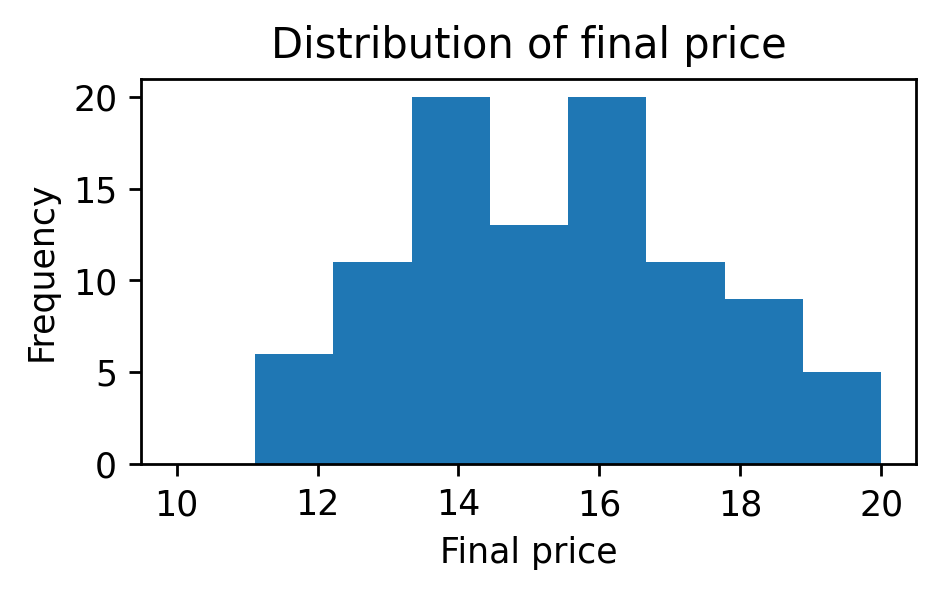

In [170]:
# Example list of data
data = np.array(final_prices)

# Divide data into 9 bins
bins = np.linspace(10, 20, 10)

# Compute histogram of the data
hist, bins = np.histogram(data, bins=bins)

# Create a bar plot using Matplotlib
plt.figure(figsize=(4, 2), dpi=250)
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='edge')

# Set the title and axis labels
plt.title('Distribution of final price')
plt.xlabel('Final price')
plt.ylabel('Frequency')

# Display the plot
plt.show()

# AI critic coaching the seller

In [297]:
def run_w_critic(buyer, seller, moderator, critic, n=5, fd=None):
    # Round 1
    wprint('==== ROUND 1 ====', fd)
    buyer.reset()
    seller.reset()
    moderator.reset()
    round_1_price = run(buyer, seller, moderator, n=10, fd=fd)
    wprint('PRICE: %s' % round_1_price, fd)
    
    # Round 2 after critic
    buyer.reset()
    moderator.reset()
    ai_feedback = critic.criticize(seller.dialog_history)
    wprint("FEEDBACK:\n%s\n\n" % ai_feedback, fd)
    acknowledgement = seller.receive_feedback(ai_feedback)
    
    wprint('==== ROUND 2 ====', fd)
    round_2_price = run(buyer, seller, moderator, n=10, fd=fd)
    wprint('PRICE: %s' % round_2_price, fd)
    
    # Round 3 after critic
#     buyer.reset()
#     moderator.reset()
#     ai_feedback = critic.criticize(seller.dialog_history)
#     wprint("FEEDBACK: %s\n\n" % ai_feedback, fd)
#     acknowledgement = seller.receive_feedback(ai_feedback)
    
#     wprint('==== ROUND 3 ====', fd)
#     price_after_feedback = run(buyer, seller, moderator, n=10, fd=fd)
#     wprint('PRICE: %s' % price_after_feedback, fd)
    return round_1_price, round_2_price

In [295]:
critic_initial_dialog_history = load_initial_instructions('instructions/critic_seller.txt')
critic = SellerCriticAgent(initial_dialog_history=critic_initial_dialog_history, agent_type="critic", engine="gpt-3.5-turbo")
pprint(critic.dialog_history)

[{'content': 'Now enter the role-playing mode. In the following conversation, '
             'you will play as a coach in a negotiation game. There will be a '
             'seller and a buyer bargaining about a balloon. Your task is to '
             'read the conversation between the seller and the buyer, then '
             'provide suggestions to the seller about how to sell the balloon '
             'to a higher price',
  'role': 'system'},
 {'content': 'Read the following conversation between the buyer and the '
             'seller, then give three suggestions to the seller about how to '
             'sell it to a higher price. Your suggestions should meet the '
             'following constraints:\n'
             '1. it should not be about the specific price\n'
             '2. it should improve the previous negotiation\n'
             '3. try to be generic and insightful',
  'role': 'user'}]


In [343]:
run_w_critic(buyer, seller, moderator, critic, n=5, fd=None)

==== ROUND 1 ====
seller: Hi, this is a good baloon and its price is $20
buyer: Would you consider selling it for $10?
---- start bargaining ----
seller: I understand your offer, but $10 is too low for this high-quality balloon. How about $18?
buyer: I appreciate your counteroffer, but would you be willing to bring the price down to $15?
seller: I can see you really like the balloon. I can give you a special deal for $17. How does that sound?
buyer: Thank you for the offer, but my budget is limited. Would you be willing to settle at $16?
seller: Alright, $16 it is! Enjoy your new balloon!
buyer: Thank you, I will enjoy it! And thank you for your willingness to negotiate.
---- start moderating ----
MODERATE have the seller and the buyer achieved a deal? Yes or No: Yes
PRICE: 
FEEDBACK:
1. Emphasize the unique features of the balloon: Highlighting the unique features, such as its durability or design, can make the buyer feel they are getting something special and increase the value of th

('', '')

In [302]:
round_1_prices = []
round_2_prices = []
with open("outputs/seller_critic_100_runs.txt", "w") as fd:
    for i in range(100):
        wprint("==== CASE %d ====" % i, fd)
        buyer.reset()
        seller.reset()
        moderator.reset()
        round_1_price, round_2_price = run_w_critic(buyer, seller, moderator, critic, n=8, fd=fd)
        if(round_1_price != -1 and round_2_price != -1):
            round_1_prices.append(float(round_1_price))
            round_2_prices.append(float(round_2_price))
        wprint("\n\n\n\n", fd)

==== CASE 0 ====
==== ROUND 1 ====
seller: Hi, this is a good baloon and its price is $20
buyer: Would you consider selling it for $10?
---- start bargaining ----
seller: I'm sorry, I cannot sell it for that low. How about $14?
buyer: Can you meet me halfway at $17?
seller: Okay, I agree to sell the balloon for $17.
buyer: Great, I will take it. Thank you!
---- start moderating ----
MODERATE have the seller and the buyer achieved a deal? Yes or No: Yes.
PRICE: 17
FEEDBACK:
1. Highlight the unique features of the balloon and its benefits compared to other balloons in the market. This could include its quality, durability, or design. This can justify the higher price and make it more valuable to the buyer.

2. Offer a lower starting price or negotiate with the buyer by raising the price offer by a smaller increment, rather than halving the asking price. This can help maintain the value of the balloon and prevent the buyer from devaluing it even further.

3. Use scarcity or urgency to cre

In [303]:
print(np.average(round_1_prices), np.std(round_1_prices))

15.572916666666666 3.613472451772979


In [304]:
print(np.average(round_2_prices), np.std(round_2_prices))

17.564583333333335 3.820912281081865


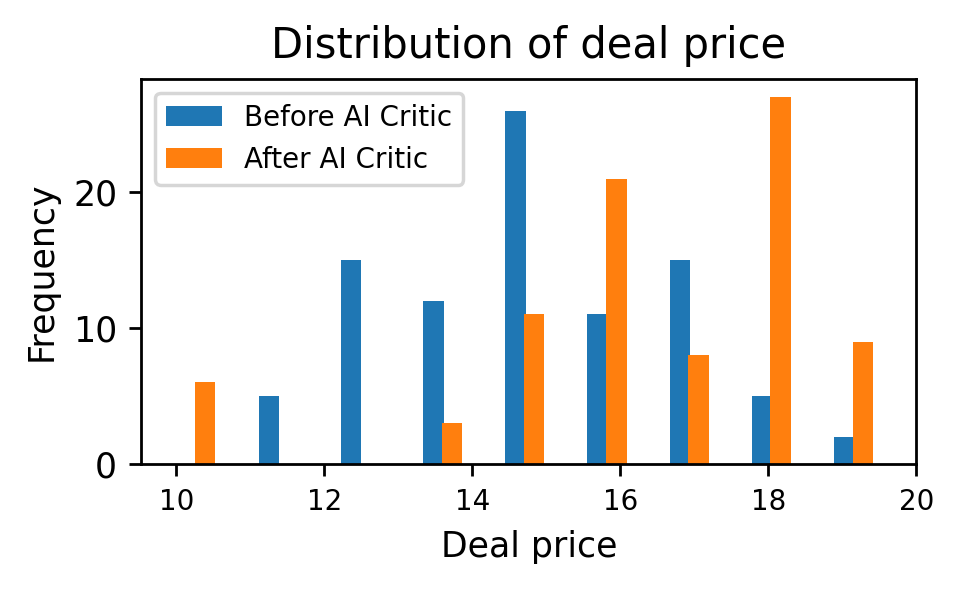

In [323]:
# Example list of data
data_1 = np.array(round_1_prices)
data_2 = np.array(round_2_prices)

# Divide data into 9 bins
bins_1 = np.linspace(10, 20, 10)
bins_2 = np.linspace(10, 20, 10)

# Compute histogram of the data
hist_1, bins_1 = np.histogram(data_1, bins=bins_1)
hist_2, bins_2 = np.histogram(data_2, bins=bins_2)

# Create a bar plot using Matplotlib
plt.figure(figsize=(4, 2), dpi=250)
plt.bar(bins_1[:-1]+0, hist_1, width=0.25 * (bins_1[1]-bins_1[0]), align='edge', label='Before AI Critic')
plt.bar(bins_2[:-1]+0.25, hist_2, width=0.25 * (bins_2[1]-bins_2[0]), align='edge', label='After AI Critic')

# Set the title and axis labels
plt.title('Distribution of deal price')
xticks = np.arange(10, 21, 2)
plt.xticks(xticks, [str(x) for x in xticks], fontsize=8)
plt.xlabel('Deal price')
plt.ylabel('Frequency')
plt.legend(fontsize=8)

# Display the plot
plt.show()